# Linear Regression



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
%matplotlib inline 

In [2]:
class LinearRegression:
    def __init__(self, learning_rate=1e-3, max_iters=250):
        self.learning_rate = learning_rate
        self.max_iters = max_iters
        self.weights = None

    def fit(self, X_train, y_train):
        X_train = self._fit_intercept(X_train)
        self.weights = np.random.rand(X_train.shape[1])

        for iter in range(self.max_iters):
            self.weights = self.weights - self.learning_rate * \
                self._grad(X_train, y_train, self.weights)
            cost = self._cost(X_train, y_train, self.weights)
            self._print_result(iter, cost)

    def predict(self, X_predict):
        """ This method predicts responses for new data.

        This method will be used for end-users to predict responses
        for future data.

        Arguments:
            X_predict: new data

        Returns: a vector of responses            
        """
        return X_predict @ self.weights

    @staticmethod
    def _cost(X_train, y_train, weights):
        """Calculates the cost w.r.t. weights

        This helper method calculates the cost w.r.t. weights

        Arguments:
            X_train: training features
            y_train: training labels.
            weights: weights vector of the model
        
        Returns: scalar value which represents the cost
        """
        dif = (y_train - X_train @ weights)
        return (dif.T @ dif) / X_train.shape[0]

    @staticmethod
    def _fit_intercept(X_train):
        """Add the intercepting term to the training dataset

        This simple helper method adds the intercepting term to the 
        training dataset.

        Arguments:
            X_train: training dataset

        Returns: training dataset with the interceptor
        """
        return np.column_stack((np.ones(X_train.shape[0]), X_train))

    @staticmethod
    def _grad(X_train, y_train, weights):
        """Calculates the gradient of the cost function w.r.t. weight vector

        This methods calculated the gradient of the cost function w.r.t. 
        weight vector.

        Arguments:
            X_train: training features
            y_train: training labels.
            weights: weights vector of the model
        
        Returns: scalar value which represents the cost
        """
        return 2 * (X_train.T @ (X_train @ weights - y_train)) / X_train.shape[0]

    @staticmethod
    def _print_result(iteration, cost):
        if (iteration <= 10) or \
            (iteration <= 100 and iteration % 10 == 0) or \
            (iteration <= 1000 and iteration % 100 == 0) or \
            (iteration <= 10000 and iteration % 1000 == 0) or \
            (iteration <= 100000 and iteration % 10000 == 0) or \
                (iteration > 100000 and iteration % 50000 == 0):
                print('iteration: {:10d}\t\tcost: {:1.4e}'.format(
                    iteration, cost))

iteration:          0		cost: 1.2793e+01
iteration:          1		cost: 8.9237e+00
iteration:          2		cost: 6.2809e+00
iteration:          3		cost: 4.4757e+00
iteration:          4		cost: 3.2424e+00
iteration:          5		cost: 2.4000e+00
iteration:          6		cost: 1.8245e+00
iteration:          7		cost: 1.4313e+00
iteration:          8		cost: 1.1626e+00
iteration:          9		cost: 9.7906e-01
iteration:         10		cost: 8.5361e-01
iteration:         20		cost: 5.8772e-01
iteration:         30		cost: 5.8004e-01
iteration:         40		cost: 5.7809e-01
iteration:         50		cost: 5.7629e-01
iteration:         60		cost: 5.7452e-01
iteration:         70		cost: 5.7277e-01
iteration:         80		cost: 5.7105e-01
iteration:         90		cost: 5.6935e-01
iteration:        100		cost: 5.6767e-01
iteration:        200		cost: 5.5212e-01


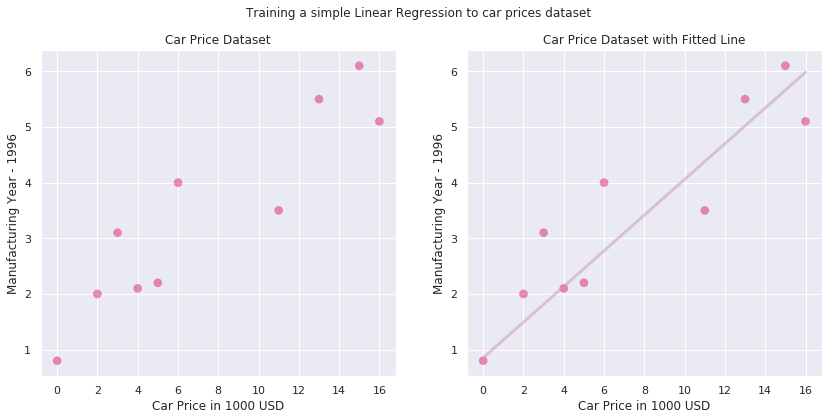

In [10]:
X_train = np.array([2010, 2000, 1999, 2012, 2001, 2002,
                        1997, 2008, 2003, 2013]).reshape((10, 1))
X_train = X_train - X_train.min()
y_train = np.array([5.5, 3.1, 2.0, 6.1, 2.1, 2.2, 0.8, 3.5, 4.0, 5.1])
model = LinearRegression()
model.fit(X_train, y_train)

predicted_points = np.linspace(X_train.min(), X_train.max(), 100) * \
        model.weights[1] + model.weights[0]

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].scatter(X_train, y_train, s=75, color='#dd1c77', alpha=0.5, edgecolors='none')
axes[0].set_title('Car Price Dataset')
axes[0].set_xlabel('Car Price in 1000 USD')
axes[0].set_ylabel('Manufacturing Year - 1996')

axes[1].scatter(X_train, y_train, s=75, color='#dd1c77', alpha=0.5, edgecolors='none')
axes[1].plot(np.linspace(X_train.min(), X_train.max(), 100),
                 predicted_points, color='#c994c7', linewidth=3, alpha=0.5)
axes[1].set_title('Car Price Dataset with Fitted Line')
axes[1].set_xlabel('Car Price in 1000 USD')
axes[1].set_ylabel('Manufacturing Year - 1996')

fig.suptitle('Training a simple Linear Regression to car prices dataset')
plt.show()